<a href="https://colab.research.google.com/github/HLF2005/waste-classification-cnn/blob/main/Waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# --- Installations (if running in Colab) ---
# Uncomment below lines if required
# !pip install tensorflow matplotlib

import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Tuple, List
from google.colab import drive


#  TensorFlow and GPU Setup


In [2]:
print('TensorFlow version:', tf.__version__)
print('GPUs:', tf.config.list_physical_devices('GPU'))

# (Optional) Avoid allocating all VRAM at once
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print('Memory growth not applied:', e)


TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#  Mount Google Drive and Copy Dataset


In [10]:
drive.mount('/content/drive')

SRC_DRIVE = '/content/drive/MyDrive/dataset/dataset'
DST_LOCAL = '/content/dataset'

if not os.path.exists(SRC_DRIVE):
    raise FileNotFoundError(f"Path not found: {SRC_DRIVE}")

if os.path.exists(DST_LOCAL):
    print('Dataset already copied locally:', DST_LOCAL)
else:
    print('Copying dataset...')
    shutil.copytree(SRC_DRIVE, DST_LOCAL)
    print('Copy completed ->', DST_LOCAL)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset already copied locally: /content/dataset


#  Dataset Configuration and Splitting


In [4]:
np.random.seed(0)
DATASET_PATH = '/content/dataset'

CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
CLASS2IDX = {c: i for i, c in enumerate(CLASSES)}

BATCH_SIZE = 16
IMAGE_SIZE = (128, 128)
EPOCHS = 100
AUTOTUNE = tf.data.AUTOTUNE

def list_image_paths(root: str):
    exts = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')
    paths, labels = [], []
    for cls in CLASSES:
        cls_dir = os.path.join(root, cls)
        if not os.path.isdir(cls_dir):
            raise FileNotFoundError(f"Dossier classe manquant: {cls_dir}")
        for f in os.listdir(cls_dir):
            if f.endswith(exts):
                paths.append(os.path.join(cls_dir, f))
                labels.append(CLASS2IDX[cls])
    paths = np.array(paths)
    labels = np.array(labels)
    idx = np.random.permutation(len(paths))
    return paths[idx], labels[idx]

paths, labels = list_image_paths(DATASET_PATH)
n = len(paths)
print('Total of images', n)
if n == 0:
    raise RuntimeError('No images found. Check DATASET_PATH and folder structure.')

split1, split2 = int(0.6 * n), int(0.8 * n)
train_p, train_y = paths[:split1], labels[:split1]
val_p,   val_y   = paths[split1:split2], labels[split1:split2]
test_p,  test_y  = paths[split2:], labels[split2:]

print('Train:', len(train_p), 'Val:', len(val_p), 'Test:', len(test_p))


Total of images 2527
Train: 1516 Val: 505 Test: 506


#  Data Augmentation and Data Pipeline

In [5]:


def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    return img, label

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMAGE_SIZE, method='bilinear')
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.one_hot(label, depth=len(CLASSES))
    return img, label

def make_ds(p, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((p, y))
    if training:
        ds = ds.shuffle(min(4096, len(p)), reshuffle_each_iteration=True)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_p, train_y, training=True)
val_ds   = make_ds(val_p, val_y, training=False)
test_ds  = make_ds(test_p, test_y, training=False)

for batch_imgs, batch_labels in train_ds.take(1):
    print('Batch images shape:', batch_imgs.shape)
    print('Batch labels shape:', batch_labels.shape)


Batch images shape: (16, 128, 128, 3)
Batch labels shape: (16, 6)


#  Model Definition

In [6]:

from tensorflow.keras import layers, models

def build_model():
    inputs = layers.Input(shape=(128, 128, 3))
    # Block 1
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.30)(x)
    # Block 2
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.30)(x)
    # Block 3
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
    return models.Model(inputs, outputs)

model = build_model()
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.02)
model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])


# Training

In [7]:

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    verbose=2
)


Epoch 1/100
95/95 - 18s - 191ms/step - accuracy: 0.2256 - loss: 1.7406 - val_accuracy: 0.2099 - val_loss: 1.6932
Epoch 2/100
95/95 - 1s - 12ms/step - accuracy: 0.2830 - loss: 1.6635 - val_accuracy: 0.2911 - val_loss: 1.6493
Epoch 3/100
95/95 - 1s - 12ms/step - accuracy: 0.3450 - loss: 1.5627 - val_accuracy: 0.3446 - val_loss: 1.5364
Epoch 4/100
95/95 - 1s - 12ms/step - accuracy: 0.3496 - loss: 1.5467 - val_accuracy: 0.3683 - val_loss: 1.4834
Epoch 5/100
95/95 - 1s - 12ms/step - accuracy: 0.3608 - loss: 1.4962 - val_accuracy: 0.3941 - val_loss: 1.4126
Epoch 6/100
95/95 - 1s - 12ms/step - accuracy: 0.3674 - loss: 1.4922 - val_accuracy: 0.4040 - val_loss: 1.4164
Epoch 7/100
95/95 - 1s - 12ms/step - accuracy: 0.3978 - loss: 1.4415 - val_accuracy: 0.4396 - val_loss: 1.4123
Epoch 8/100
95/95 - 1s - 12ms/step - accuracy: 0.4294 - loss: 1.4006 - val_accuracy: 0.3881 - val_loss: 1.4591
Epoch 9/100
95/95 - 1s - 12ms/step - accuracy: 0.4380 - loss: 1.3857 - val_accuracy: 0.4673 - val_loss: 1.3588

#  Evaluation


In [8]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


Test loss: 0.7094868421554565
Test accuracy: 0.790513813495636


#  Visualization


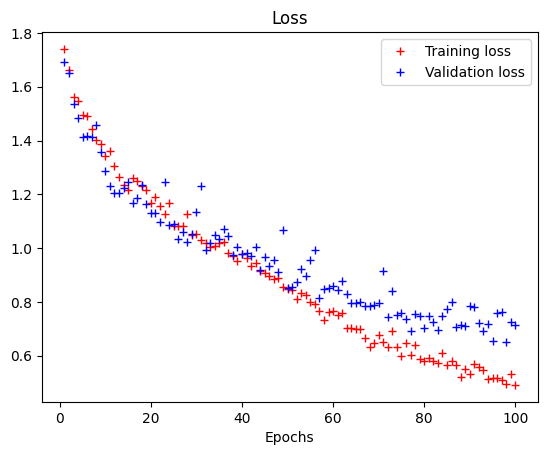

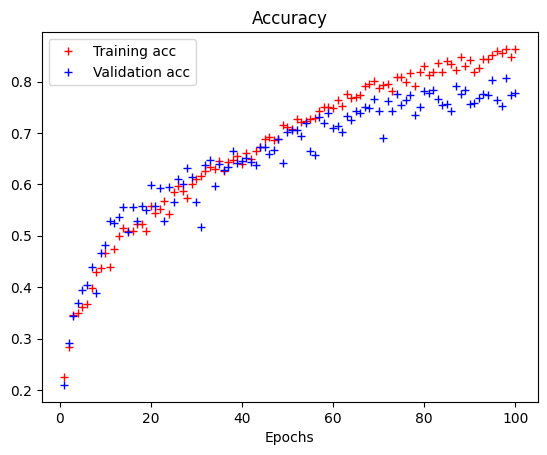

In [9]:
epochs_range = range(1, len(history.history['loss']) + 1)
plt.figure()
plt.title('Loss')
plt.plot(epochs_range, history.history['loss'], 'r+', label='Training loss')
plt.plot(epochs_range, history.history.get('val_loss', []), 'b+', label='Validation loss')
plt.legend(); plt.xlabel('Epochs'); plt.show()

plt.figure()
plt.title('Accuracy')
plt.plot(epochs_range, history.history['accuracy'], 'r+', label='Training acc')
plt.plot(epochs_range, history.history.get('val_accuracy', []), 'b+', label='Validation acc')
plt.legend(); plt.xlabel('Epochs'); plt.show()
